### Heston Model

In [215]:
def get_loss(kappa, res2, sigma):
    S_matrix = np.zeros(shape=(len(res2)), dtype=np.float64)
    S_matrix[0] = res2[0]
    for i in range(1,len(res2)):
        S_matrix[i] = S_matrix[i-1] + kappa*(sigma**2 - res2[i-1])
    return (S_matrix**2).sum()

In [216]:
def get_lognormal_statistics_(prices):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)
  sigma = np.std(log_returns, ddof=1)
  residuals = (log_returns-mu)
  res_2 = residuals**2
  sigma_of_sigma = np.std(res_2, ddof=1)
  kappa = minimize_scalar(lambda x: get_loss(x,res_2,sigma), method='brent', tol=10**(-10)).x

  return mu, sigma, sigma_of_sigma, kappa, res_2[0]

In [212]:
Hes_matrix = np.random.normal(0, 1, size=(len(simulation_dates), num_sim, num_periods))

In [217]:
@njit
def simulate_heston_var(num_sim, S_0, S_mu, S_Sigma, kappa, delta_t, T, Z):
  # Initializations
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)
 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      prev = S_matrix[i][j-1]
      S_matrix[i][j] = prev + kappa*(S_mu**2-prev)*delta_t + S_Sigma*np.sqrt(prev)*Z[i][j-1]
      if(S_matrix[i][j]<0):
        S_matrix[i][j] = S_mu**2
      
  return S_matrix

In [218]:
@njit
def simulate_GBM_(num_sim, S_0, r, sigma, delta_t, T, Z):  # NOTE: For exact GMB simply set r=mu while calling
  # Initializations
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)

  # We are using the form derived by Ito's lemma 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      v = r - 0.5*(sigma[i][j]**2)
      log_diff = v*delta_t + (sigma[i][j]*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix

In [224]:
# GBM without Variance Reduction
Hes_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  
  date_index = simulation_dates.get_loc(date)
  delta = len(product_lifetime[date:])
  tau = delta / 252 ### time diff in years
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100 ### yearly interest
  _, sigma, sigma_sigma, kappa, init_sigma = get_lognormal_statistics_(prices)  ### all daily indicators
  eff_r = r #- get_div_rate(date)/100

  variance = simulate_heston_var(num_sim, init_sigma, sigma, sigma_sigma, kappa, delta_t, tau, Z=Hes_matrix[date_index])
  simulated_prices = simulate_GBM_(num_sim, prices[-1], eff_r/252, variance**(1/2), delta_t, tau, Z=Z_matrix[date_index])
  
  payoffs = np.exp(-eff_r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  Hes_expected_values.append(expected_value)

#### Plotting the Results aka The Moment of Truth

In [307]:
simulation_reults = pd.DataFrame(index=simulation_dates)
product_prices = product_prices[product_prices.index >= start_date]

# For some reason the product was priced on Labour Day
try:
    product_prices = product_prices.drop(pd.to_datetime("2023-09-04"))  # Labour day nonesense
except:
    print("Labour Day price was already removed!")
assert len(product_prices) == len(simulation_reults)

# Gather data into a single dataframe
simulation_reults['Actual'] = product_prices["value"]
simulation_reults['GBM'] = GBM_expected_values
# simulation_reults['closed']= closed_expected_values
simulation_reults['CIR']= CIR_expected_values
simulation_reults['HES']= Hes_expected_values


simulation_reults.head()

Labour Day price was already removed!


,Actual,GBM,CIR,HES
date,,,,
2023-08-09,1124.23,1135.624032,1135.121102,1127.282683
2023-08-10,1125.79,1129.333724,1128.366196,1122.625586
2023-08-11,1122.01,1129.135939,1128.256528,1121.553533
2023-08-14,1125.99,1127.859966,1126.833743,1119.946785
2023-08-15,1121.69,1132.517024,1131.939558,1123.763073


Text(0, 0.5, 'Derivative Price in USD')

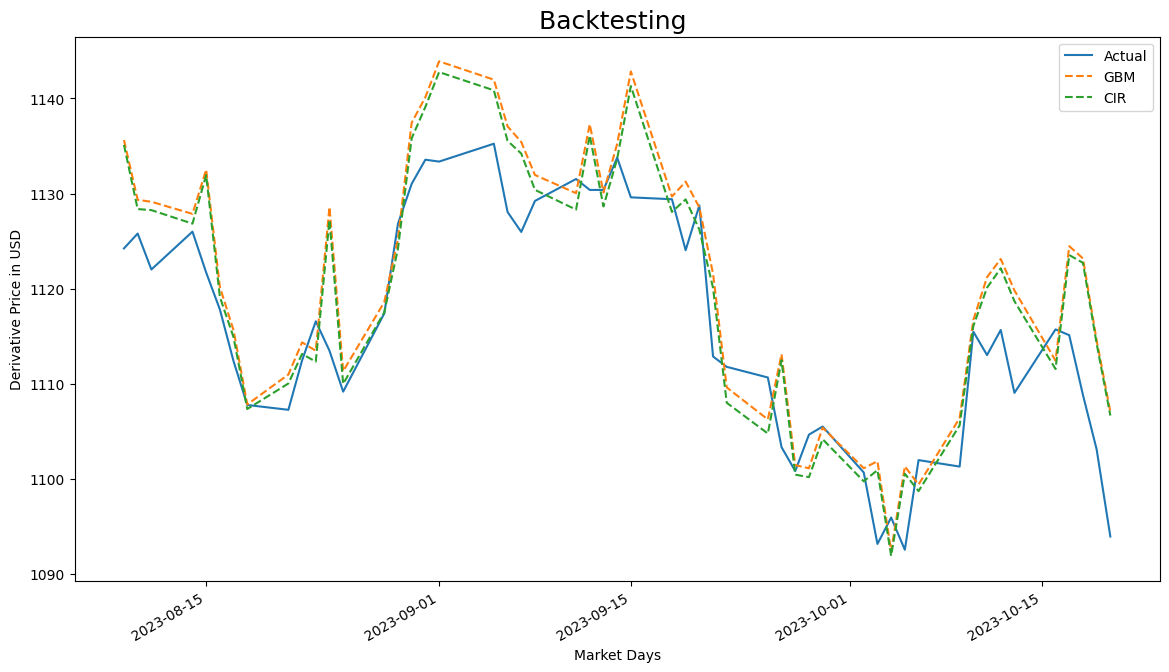

In [308]:
plt.figure(figsize=(14,8))
plt.title('Backtesting ',fontdict={"fontsize":18})

simulation_reults['Actual'].plot(legend=True)
simulation_reults['GBM'].plot(legend=True,style="--")
# simulation_reults['closed'].plot(legend=True,style="--")
simulation_reults['CIR'].plot(legend=True,style="--")
#simulation_reults['HES'].plot(legend=True,style="--")


plt.xlabel('Market Days')
plt.ylabel('Derivative Price in USD')

#### Hmm maybe the Error Decreased?

In [310]:
mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM'].to_list())
print(f'Mean Absolute Error for GBM:\t\t{mean_abs_error}')
print(f'Mean Squared Error for GBM:\t\t{mean_sq_error}\n')

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['CIR'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['CIR'].to_list())
print(f'Mean Absolute Error for CIR:\t{mean_abs_error}')
print(f'Mean Squared Error for CIR:\t{mean_sq_error}\n')

# mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['HES'].to_list())
# mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['HES'].to_list())
# print(f'Mean Absolute Error for HES:\t{mean_abs_error}')
# print(f'Mean Squared Error for HES:\t{mean_sq_error}\n')

Mean Absolute Error for GBM:		5.566625103792319
Mean Squared Error for GBM:		49.00061315540043

Mean Absolute Error for CIR:	5.168806438410518
Mean Squared Error for CIR:	41.3561840960765

